sklearn07_1_利用集成方法预测贷款申请者是否可以获得贷款

**案例描述：**
> 本案例为《机器学习实践》第七章集成模型的课程配套代码。通过尝试建立不同的集成模型，预测贷款申请者是否可以获得贷款，数据集来自Kaggle数据科学竞赛平台。

**数据集：**
> file_path = "./dataSets/data_chap7/loan.csv".   <br>
> 数据集loan包含13个特征，共614个样本点。记录了一些申请者的情况，包括基本信息和一些信用指标。<br>
>利用集成方法来训练一个分类器，用于预测申请者是否能获得贷款，这是一个二分类问题<br>

>> |字段|说明|
|:--|:--|
|Loan_ID|申请人ID|
|Gender|性别（Male：男，Female：女）|
|Married|婚姻状况（Yes：已婚，No：未婚）|
|Denpendents|抚养人个数（0， 1，2,  3+（三个以上））|
|Education|教育情况（Graduate：毕业生，Not Graduate：非毕业生）|
|Self_Employed|是否为自由职业者（Yes：是，No：否）|
|AppplicantIncome|申请人收入|
|CoapplicantIncome|共同申请人收入|
|LoanAmount|贷款金额|
|Loan_Amount_Term|还款期限|
|Credit_History|是否有违约历史（1：是，0：否）|
|Propperty_Area|居住地段（Semiurban：半城市，Urban：城市，Rural：农村）|
|Loan_Status（目标）|是否获得贷款（Y：是，N：否）|

**学习目标：**
> 完成集成模型和ensemble模块练习
>>● Bagging <br>
>>>随机森林

>> ●Boosting <br>
>>>AdaBoost<br>
>>>GBDT<br>

>> ●Voting Classifier  <br>

**集成思想：**
> **经常用于工业应用领域，机器学习竞赛中。**
> ![](./imgs/chap07/fig07_01.png)

**sklearn中的ensemble集成模块：**
> 包括的主要类：
>> |类	|说明|
|---:|---:|
|ensemble.BaggingClassifier	|Bagging分类|
|ensemble.BaggingRegressor	|Bagging回归|
|ensemble.RandomForestClassifier	|随机森林分类|
|ensemble.RandomForestRegressor	|随机森林回归|
|ensemble.AdaBoostClassifier	|AdaBoost分类|
|ensemble.AdaBoostRegressor	|AdaBoost回归|
|ensemble.GradientBoostingClassifier	|梯度提升分类|
|ensemble.GradientBoostingRegressor	|梯度提升回归|
|Ensemble.VotingClassifier	|投票表决分类器|


In [2]:
## 忽略警告
import warnings
warnings.filterwarnings('ignore')

**导入必要包**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

# 数据预处理

**读入数据**

In [4]:
## 读取数据

file_path = "./dataSets/data_chap7/loan.csv"
loan = pd.read_csv(file_path)
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
## shape

loan.shape

(614, 13)

In [6]:
## info()
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


分析： 从info()基本信息看，数据存在缺失值

## 缺失值处理

**检查缺失值情况**

In [7]:
# 检查缺失值
loan.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
## 获取存在缺失值的特征名,way1:
abs_col = loan.isnull().any()
abs_col[abs_col == True].index

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [9]:
## 获取存在缺失值的特征名,way2:
loan.isnull().any()[loan.isnull().any().values==True].index

Index(['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

需要对缺失值进行处理，具体为：
> (1) 连续型特征采用其平均值填充
>> 特征：`'LoanAmount',`

>(2) 离散型特征采用其众数进行填充,
>> 特征：`'Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History'`   <br>

**数据预处理--缺失值处理**

In [10]:
# 连续变量"LoanAmount"用其均值进行填充
loan["LoanAmount"].fillna(loan["LoanAmount"].mean(),inplace=True)

In [11]:
## 求众数
print(loan['Gender'].mode())
print(type(loan['Gender'].mode()))
print(loan['Gender'].mode().values)
print(loan['Gender'].mode().values[0])

0    Male
dtype: object
<class 'pandas.core.series.Series'>
['Male']
Male


In [12]:
## 离散变量用每列的众数进行填充
dis_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']
for col in dis_cols:
    loan[col].fillna(loan[col].mode().values[0], inplace=True)

In [13]:
## 查看缺失值是否填充完毕
loan.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [14]:
## 考察特征 'Loan_Amount_Term'
loan[ 'Loan_Amount_Term'].unique()

array([360., 120., 240., 180.,  60., 300., 480.,  36.,  84.,  12.])

说明：特征` 'Loan_Amount_Term'`可作为连续变量，也可作为有序的离散变量。这里，采用众数进行缺失值填充，但后续把他看做一个连续特征，不进行离散化编码。

## 特征数值编码

**数据预处理--离散特征数值编码**
> (1) 有序的离散特征编码用`map()`:
>> `'Dependents'`,孩子的数量0,1,2,3+有大小顺序关系在里面

>(2)无序的离散特征编码用`OneHot`:
>>`'Gender','Married','Education','Property_Area','Self_Employed','Credit_History'`

In [15]:
## 有序离散特征'Dependents'数值编码
loan['Dependents'].unique()

array(['0', '1', '2', '3+'], dtype=object)

In [16]:
## 使用map()对'Dependents'进行数值编码
loan['Dependents'] = loan['Dependents'].map({"0":0,"1":1,"2":2,"3+":3})

In [17]:
## 无序离散特征编码，使用one-hot编码
dis_cols = ['Gender','Married','Education','Property_Area','Self_Employed','Credit_History']
loan = pd.get_dummies(data=loan,columns=dis_cols)

In [18]:
## 查看loan数据前几行
loan.head()

,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0
0,LP001002,0,5849,0.0,146.412162,360.0,Y,0,1,1,0,1,0,0,0,1,1,0,0,1
1,LP001003,1,4583,1508.0,128.000000,360.0,N,0,1,0,1,1,0,1,0,0,1,0,0,1
2,LP001005,0,3000,0.0,66.000000,360.0,Y,0,1,0,1,1,0,0,0,1,0,1,0,1
3,LP001006,0,2583,2358.0,120.000000,360.0,Y,0,1,0,1,0,1,0,0,1,1,0,0,1
4,LP001008,0,6000,0.0,141.000000,360.0,Y,0,1,1,0,1,0,0,0,1,1,0,0,1


In [19]:
## 查看shape
loan.shape

(614, 20)

## 数据分离与划分
> 数据分离：
>> 去掉无关特征，把数据分离为X，y,即目标与数据分离

> 数据划分：
>> train,test

### 分离数据

In [20]:
## drop()去掉无关特征"Loan_ID",该特征与我们预测的目标“Loan_Status”没任何关系，属于无关特征
loan = loan.drop(['Loan_ID'],axis=1).copy()
## 分离出目标y
y = loan['Loan_Status'].copy()

## 分离数据X
X = loan.drop(['Loan_Status'],axis=1).copy()

In [21]:
X.shape, y.shape

((614, 18), (614,))

In [22]:
## 查看目标y的分布
y.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [23]:
##  目标变量数值编码：是-->0, 否->1
y = y.map({'Y':0, 'N':1})

In [24]:
## 查看目标y的分布
y.value_counts()

0    422
1    192
Name: Loan_Status, dtype: int64

分析：目标y的分布不均匀，所以在划分train和test的时候，需要考虑样本均衡问题，即设置参数`stratify`

### 划分数据

In [25]:
# 划分训练测试集:训练集（85%），测试集（15%），并采用分层抽样
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15 ,
                                                random_state=10,
                                                stratify=y )

# Bagging
> **装袋法**：
>> 原理：**并行的建立一些学习器**，尽可能使其相互独立。从方差-偏差的角度看，可以有效减小方差,用于抑制模型过拟合。 <br>
>> 核心方法：自助抽样(Bootstrap)和聚合(Aggregating)   <br>
>> ![](./imgs/chap07/fig07_02.png)
>>> 名词：袋外误差(out of bag)：oob_score

> sklearn中Bagging：
>> `BaggingClassifier`和`BaggingRegressor`类
>>> |参数	|功能|
|---:|---:|
|n_estimators	|基模型的个数，默认为10|
|base_estimator	|使用的基模型，默认是决策树|
|bootstrap	|样本的抽样方式，默认为True（有放回）|
|bootstrap_features 	|特征的抽样方式，默认为False（无放回）|
|obb_score	|是否使用袋外样本估计泛化能力，默认为False|


## BaggingClassifier
> (1)分别使用`DecisionTreeClassifier`和`LogisticRegression`作为基模型， <br>(2) 然后采用集成模型对本数据集进行分类，<br> (3)考察模型性能，<br>  (4)Gridsearch调优<br>

### base_estimator=DecisionTreeClassifier

In [26]:
## 载入基学习器:决策树分类器
from sklearn.tree import DecisionTreeClassifier

In [27]:
## 建立基于决策树的Bagging装袋模型
from sklearn.ensemble import BaggingClassifier
model_DF = DecisionTreeClassifier(random_state=10)
bag_DF = BaggingClassifier(base_estimator = model_DF,
                          oob_score = True,
                          random_state = 10)
bag_DF

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=10,
                                                        splitter='best'),
      

In [28]:
## 训练模型
bag_DF.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=10,
                                                        splitter='best'),
      

In [29]:
## 模型预测predict
### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_bd = bag_DF.predict_proba(X_test)[:,1]
print(y_prob_bd)
### predict2：测试集的预测标签(y_pred)
y_pred_bd = bag_DF.predict(X_test)
print(y_pred_bd)

[0.5 0.  0.  0.  0.1 0.2 1.  0.2 0.3 0.1 0.  0.  0.8 0.2 0.  0.  0.1 0.3
 0.3 0.  0.  0.4 0.1 0.  0.4 0.4 0.1 0.9 0.  0.5 0.  0.4 0.2 0.  0.1 0.
 0.  0.2 0.4 0.2 0.  0.  0.3 0.5 0.2 0.6 0.  0.8 0.1 0.  1.  0.1 0.3 0.1
 0.3 0.5 0.1 0.2 0.4 1.  0.2 0.1 0.1 0.9 0.6 0.2 0.  0.  0.2 0.  0.1 0.3
 0.2 0.8 0.5 0.3 0.  0.3 0.1 0.2 0.1 0.  0.6 0.7 0.2 0.1 0.  0.1 0.2 0.1
 0.2 0.9 0.1]
[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0]


predict_proba与predict的概念与区别

predict_proba——返回预测属于某标签的概率——概率

predict——返回预测标签——预测结果

 参考网站：https://blog.csdn.net/anan15151529/article/details/102632463

In [30]:
## 模型的得分：查看袋外样本得分
bag_DF.oob_score_

0.7735124760076776

In [31]:
## 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=y_pred_bd))

              precision    recall  f1-score   support

           0       0.78      0.97      0.86        64
           1       0.85      0.38      0.52        29

    accuracy                           0.78        93
   macro avg       0.81      0.67      0.69        93
weighted avg       0.80      0.78      0.76        93



In [32]:
## 绘制ROC曲线并计算AUC
from sklearn.metrics import roc_curve,auc

fpr,tpr,threshold = roc_curve(y_true=y_test, y_score=y_prob_bd)
print("AUC值：",auc(fpr,tpr))

AUC值： 0.7882543103448276


Text(0.5, 1.0, 'ROC Curve')

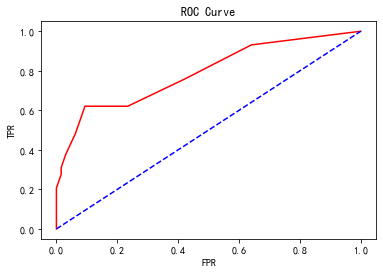

In [33]:
## 绘ROC曲线
plt.plot(fpr, tpr, 'r-')          # 曲线
plt.plot([0, 1], [0, 1], 'b--')   #  直线
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

### base_estimator=LogisticRegresssion

In [35]:
## 载入基学习器:逻辑回归
from sklearn.linear_model import LogisticRegression
model_LR= LogisticRegression(random_state=10,class_weight="balanced")

## 建立基于逻辑回归的装袋模型
from sklearn.ensemble import BaggingClassifier
bag_LR=BaggingClassifier(base_estimator=model_LR,oob_score=True,random_state=10)

## 训练模型
bag_LR.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0,
                                                    class_weight='balanced',
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=10,
                                                    solver='warn', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None

In [36]:
## 模型预测predict
### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_bl = bag_LR.predict_proba(X_test)[:,1]
### predict2：测试集的预测标签(y_pred)
y_pred_bl = bag_LR.predict(X_test)

In [37]:
## 模型的得分：查看袋外样本得分
bag_LR.oob_score_

0.7581573896353166

In [38]:
# 输出分类报告
print(classification_report(y_true=y_test,y_pred=y_pred_bl))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84        64
           1       0.71      0.41      0.52        29

    accuracy                           0.76        93
   macro avg       0.74      0.67      0.68        93
weighted avg       0.75      0.76      0.74        93



In [39]:
## 绘制ROC曲线并计算AUC
fpr,tpr,threshold = roc_curve(y_true=y_test, y_score=y_prob_bl)
print("AUC值：",auc(fpr,tpr))

AUC值： 0.7155172413793103


Text(0.5, 1.0, 'ROC Curve')

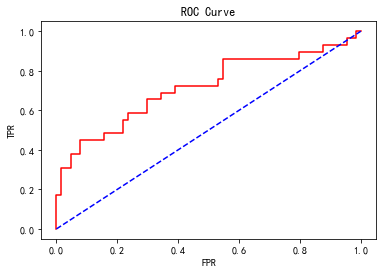

In [40]:
## 绘制ROC曲线
plt.plot(fpr, tpr, 'r-')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

分析：通过AUC值的比较，可看出针对该问题，`bag_DF`效果要比`bag_LR`好一些，所以后续重点对`bag_DF`进行调参。

### 基于决策树的Bagging模型参数调优

> 使用`GridSearchCV`对模型`bag_DF`调参,可调参数：
>> (1) 基模型个数：`n_estimators` = [20,50,...]  <br>
(2) 特征选取方式:`bootstrap_features`= [True,False]  <br>
>>> `True`:有放回的选择部分features，`False`:无放回的选择部分features，

In [41]:
## 网格搜索调参
from sklearn.model_selection import GridSearchCV

## 构建网格参数字典
## (1)"n_estimators"：决策树基模型的数量取值序列;(2)"bootstrap_features"：是否特征抽取
grid_n = [20,50,100,150,200,500]
grid_fea = [True,False]
param_grid = {"n_estimators":grid_n,"bootstrap_features":grid_fea}

## 构造网格搜索
grid_search = GridSearchCV(estimator=bag_DF,
                           param_grid=param_grid,
                           scoring = 'roc_auc',
                           cv=5
                          )
## search...
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=2,
                                                   

In [42]:
# 返回最优参数
grid_search.best_params_

{'bootstrap_features': True, 'n_estimators': 100}

In [43]:
##  采用grid_search的最优模型进行预测
### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_bd_best = grid_search.predict_proba(X_test)[:,1]
### predict2：测试集的预测标签(y_pred)
y_pred_bd_best = grid_search.predict(X_test)

In [44]:
# 输出分类报告
print(classification_report(y_true=y_test,y_pred=y_pred_bd_best))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86        64
           1       0.91      0.34      0.50        29

    accuracy                           0.78        93
   macro avg       0.84      0.66      0.68        93
weighted avg       0.81      0.78      0.75        93



AUC值： 0.7578125


Text(0.5, 1.0, 'ROC Curve')

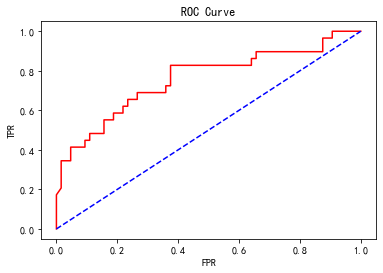

In [45]:
# 绘制ROC曲线并计算AUC
fpr,tpr,threshold = roc_curve(y_true=y_test,y_score=y_prob_bd_best)
print("AUC值：",auc(fpr,tpr))

## 绘ROC图
plt.plot(fpr, tpr, 'r-')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

分析： 结果一般般

## RandomForest随机森林
> **是Bagging的典型代表，其基模型为决策树**
>>**“随机”是核心**，“森林”指建立多棵决策树进行组合。

>>两个“随机”：
>>>(1) 对样本进行有放回抽样（boostrap）   <br>
(2) 对特征进行随机抽样（共𝑑个特征，一般随机选取$$m=\log _{2} d+1$$

> `RandomForestClassifier类`
>> |参数	|功能|
|---:|---:|
|n_estimators	|基决策树的个数，默认为10|
|criterion	|最佳划分的评价标准，默认为“gini”，可选“entropy”|
|max_features	|建立每棵树使用的特征个数，默认为“auto”（m=sqrt(d)），还可选：“log2”,“None”（m=d），也可直接输入个数（正整数）|
|bootstrap	|样本的抽样方式，默认为True（有放回）|
|oob_score	|是否使用袋外样本估计泛化能力，默认为False|
|class_weight	|设置分类权重，默认为“None”|


>`RandomForestRegressor`类
>> |参数	|功能|
|---:|---:|
|n_estimators	|基决策树的个数，默认为10|
|criterion	|最佳划分的评价标准，默认为“mse”（均方误差），可选“mae“（平均绝对误差）|
|max_features	|建立每棵树使用的特征个数，默认为“auto”（m=sqrt(d)），还可选：“log2”,“None”（m=d），也可直接输入个数（正整数）|
|bootstrap	|样本的抽样方式，默认为True（有放回）|
|oob_score	|是否使用袋外样本估计泛化能力，默认为False|



>> 两者参数的不同之处：
>>> （1）`criterion`标准不同； (2)回归没有参数`class_weight`，因为没有类别






### 构建随机森林模型并预测

In [46]:
# 载入算法类
from  sklearn.ensemble import RandomForestClassifier

# 设置基模型个数列表
grid_n = [20, 40, 60, 80, 100, 120]

# 计算在不同基模型个数下的袋外样本得分"oob_score_"
oob_score = []

for item in grid_n:
    model = RandomForestClassifier(n_estimators=item, random_state=10, oob_score=True)
    model.fit(X_train, y_train)
    oob_score.append(model.oob_score_)

Text(0.5, 1.0, 'Line chart')

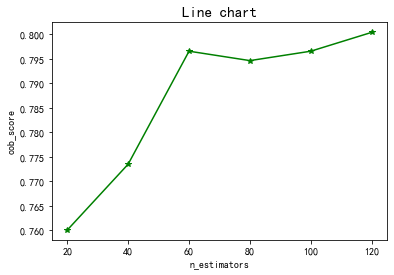

In [47]:
## oob_score随着树的增多情况
plt.plot(grid_n, oob_score, 'g-*')
plt.xlabel('n_estimators')
plt.ylabel('oob_score')
plt.title('Line chart', fontsize=15)

分析：oob_score随着树的增多呈现提升的趋势，但是其结果与`random_state`设置也有关系，有时出现波动

### 随机森林`GridSearchCV`参数调优
> 基模型为;`RandomForestClassifier()`
> `GridSearchCV`可调参数：
>> (1)`'n_estimators'`:grid_n,基模型个数  <br>
(2) `'max_features'`:grid_fea, 选取特征最大个数,这里一共18个特征  <br>
(3) `'class_weight'`:grid_weight，['balanced', None],是否考虑类别平衡<br>

>注意;需要一定的运行时间

In [48]:
## 网格搜索参数调优

## 创建基模型
model_RF = RandomForestClassifier(random_state=10)

## 构建参数网格KV
grid_n = [20, 50, 100, 150, 200, 500]
grid_fea = np.arange(2, 19) 
grid_weight = ['balanced', None]
param_grid = {'n_estimators':grid_n, 'max_features':grid_fea, 'class_weight':grid_weight}

## 生成GridSearchCV实例
grid_search = GridSearchCV(estimator=model_RF, 
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc')
## searching....
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [49]:
## 返回最优参数
grid_search.best_params_


{'class_weight': None, 'max_features': 6, 'n_estimators': 500}

In [52]:
##  采用grid_search的最优模型进行预测

### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_rf_best = grid_search.predict_proba(X_test)[:,1]

### predict2：测试集的预测标签(y_pred)
y_pred_rf_best = grid_search.grid_search.predict(X_test)

AttributeError: 'GridSearchCV' object has no attribute 'grid_search'

In [53]:
## 输出分类报告
print(classification_report(y_true=y_test,y_pred=y_pred_rf_best))

NameError: name 'y_pred_rf_best' is not defined

AUC值： 0.7944504310344827


Text(0.5, 1.0, 'ROC Curve')

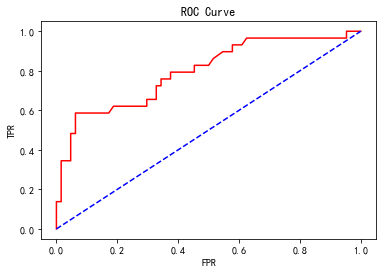

In [54]:
## 绘制ROC曲线并计算AUC
fpr,tpr,threshold = roc_curve(y_true=y_test,y_score=y_prob_rf_best)
print("AUC值：",auc(fpr,tpr))

## 画图ROC
plt.plot(fpr, tpr, 'r-')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

分析： 从AUC看，性能还是有所提升的。

### 特征重要性
> (1) 经过gridSearch后，得到最优模型estimator  <br>
(2) 使用最优模型进行fit()  <br>
(3) 考察特征重要性并绘图显示

In [55]:
## 提炼出最优模型(estimator)
best_RF = grid_search.best_estimator_

## 使用最优模型训练
best_RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [56]:
## 特征重要性评估
fea_importance = best_RF.feature_importances_
fea_importance

array([0.04390441, 0.17865683, 0.10490325, 0.16950222, 0.04730121,
       0.01283687, 0.01269846, 0.01389112, 0.0134134 , 0.01297559,
       0.01272553, 0.01754842, 0.01861473, 0.01632628, 0.01081247,
       0.01090493, 0.1411791 , 0.16180518])

In [57]:
## 特征名称
index = X_train.columns
index

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Gender_Female', 'Gender_Male', 'Married_No',
       'Married_Yes', 'Education_Graduate', 'Education_Not Graduate',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Self_Employed_No', 'Self_Employed_Yes', 'Credit_History_0.0',
       'Credit_History_1.0'],
      dtype='object')

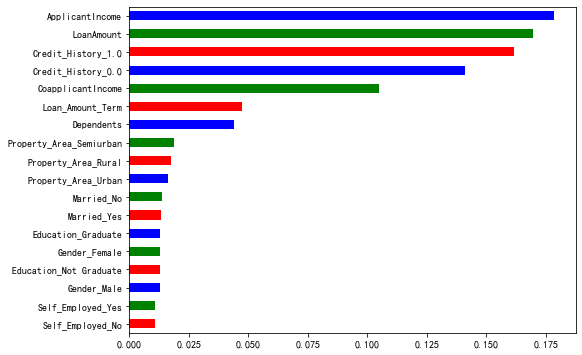

In [58]:
## 可视化特征重要性,降序排列，横向柱形图输出
plt.figure(figsize=(8,6))
pd.Series(fea_importance,index=index).sort_values().plot(kind='barh',color=["r",'g','b'])

分析：申请人收入、贷款金额、是否有违约历史、共同申请人收入这五个特征的重要性排在前五位。
？？如何实现每一条都不同颜色呢？？

# Boosting
> 提升法：
>> 串行的建立一些学习器，通过一定策略提升弱分类器效果，组合得到强分类器。从方差-偏差的角度看，可以有效减小偏差。 <br>
>> 典型代表：AdaBoost,类似“打补丁”，即后一个学习器不断的为前一个学习器打补丁

## AdaBoost
>> **常用于分类任务**  <br>
>> ![](./imgs/chap07/fig07_03.png)

> `AdaBoostClassifier`类
>>|参数	|功能|
|---:|---:|
|base_estimator	|基学习器的设置，默认是决策树|
|n_estimators	|基学习器的个数，默认为50|
|Learining_rate	|学习率的设置，默认为1.0|
|algorithm	|二分类推广到多分类使用的算法，默认为“SAMME.R”，可选“SAMME”|
>>>> 说明： "SAMME.R": 采用概率值计算;    "SAMME":直接比值计算


>>|属性	|说明|
|---:|---:|
|estimator_weights_ 	|每个弱分类器的权重|
|estimator_errors_ 	|每个弱分类器的分类误差|
|feature_importances_ 	|特征重要性|


### AdaBoost(base_estimator=None)
> 基模型为分类树模型的AdaBoost()集成模型分析,其基分类器默认为决策树

#### 构建模型并训练

In [59]:
# 载入算法类
from  sklearn.ensemble import AdaBoostClassifier

## 构建模型并训练：其基分类器默认为决策树，默认学习器的个数为50
## 使用SAMME算法二分类时，退化为标准AdaBoost
model_ada = AdaBoostClassifier(random_state=10,algorithm="SAMME")
model_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=10)

#### 模型预测与评价

In [60]:
###  模型预测
### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_ada = model_ada.predict_proba(X_test)[:,1]

### predict2：测试集的预测标签(y_pred)
y_pred_ada= model_ada.predict(X_test)

In [61]:
# 计算AUC
fpr, tpr, threshold = roc_curve(y_true=y_test,y_score=y_prob_ada)
print('AUC值：', auc(fpr, tpr))

AUC值： 0.707165948275862


#### 弱学习器权重与误差变化

In [62]:
## 获取每个弱分类器的权重
weights = model_ada.estimator_weights_
weights

array([1.48774098, 0.21940535, 0.16976415, 0.29579791, 0.05535246,
       0.27052932, 0.09144288, 0.14782437, 0.11924969, 0.11208143,
       0.13087636, 0.1207311 , 0.10119864, 0.21659741, 0.19253753,
       0.12925381, 0.0923467 , 0.1432675 , 0.2010794 , 0.16304503,
       0.19033601, 0.20952184, 0.13312598, 0.14634754, 0.13782049,
       0.05949923, 0.04854591, 0.08345711, 0.07970978, 0.07625216,
       0.07305098, 0.07007791, 0.08614685, 0.08069399, 0.06553846,
       0.06307493, 0.16928989, 0.07838478, 0.05427624, 0.03823093,
       0.0648165 , 0.06240485, 0.06014161, 0.10765867, 0.1313072 ,
       0.14564669, 0.20132943, 0.14734554, 0.06743611, 0.11088351])

In [63]:
## 获取每个弱分类器的分类误差
errors = model_ada.estimator_errors_

errors

array([0.18426104, 0.44536765, 0.4576606 , 0.42658504, 0.48616542,
       0.43277715, 0.4771552 , 0.46311106, 0.47022286, 0.47200894,
       0.46732753, 0.46985383, 0.47472191, 0.44606136, 0.45201377,
       0.46773146, 0.47692972, 0.46424426, 0.44989885, 0.4593288 ,
       0.45255914, 0.44781032, 0.46676757, 0.46347828, 0.46559931,
       0.48512958, 0.48786591, 0.47914782, 0.4800831 , 0.48094619,
       0.48174537, 0.48248769, 0.4784766 , 0.47983744, 0.48362125,
       0.48423649, 0.45777831, 0.48041383, 0.48643427, 0.49044343,
       0.48380155, 0.48440385, 0.48496913, 0.4731113 , 0.46722028,
       0.46365256, 0.44983697, 0.46323011, 0.48314736, 0.47230749])

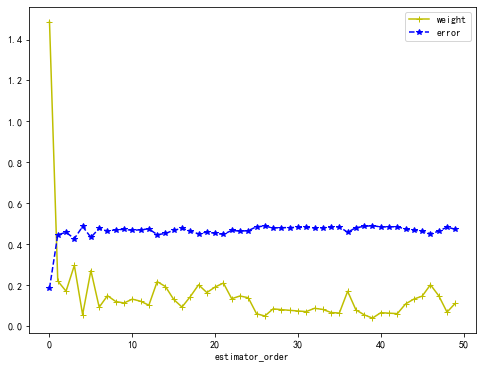

In [64]:
## 弱分类器的权重和误差变化折线图
plt.figure(figsize=(8, 6))
plt.plot(model_ada.estimator_weights_, 'y-+', label='weight')
plt.plot(model_ada.estimator_errors_, 'b--*', label='error')
plt.xlabel('estimator_order')
plt.legend()

分析：第一个弱分类器权重最高，误差最低，其余弱分类器间权重和误差较为接近。可通过调整学习率`Learining_rate`改变这种情况：
> (1) 当`n_estimators`较大时，设置小的学习率； <br>
(2) 当`n_estimators`较小时，设置大的学习率


#### 特征重要性

In [65]:
# 模型model_ada的特征重要新
fea_importances= model_ada.feature_importances_
fea_importances

array([0.02887013, 0.2593519 , 0.12840317, 0.15838533, 0.06686316,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01909604, 0.        , 0.03942672, 0.        , 0.        ,
       0.        , 0.044024  , 0.25557956])

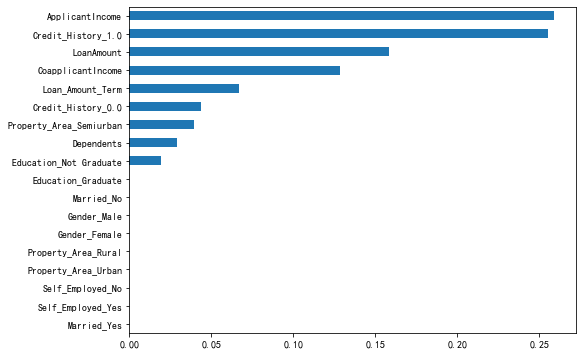

In [66]:
# 特征重要性评估
plt.figure(figsize=(8, 6))
pd.Series(model_ada.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')

分析：申请人收入、有违约历史、贷款金额、共同申请人收入、还款期限这五个特征的重要性排在前五位，与前面分析一致。

#### 学习率对弱学习器的影响
> 考察学习率对对分类误差的影响

In [67]:
# 学习率对分类误差的影响
grid_rate = np.linspace(0.01, 1, 10)

# 不同学习率下的模型测试集得分
error = []

for item in grid_rate:
    model = AdaBoostClassifier(random_state=10, learning_rate=item)
    model.fit(X_train, y_train)
    error.append(model.score(X_test, y_test))
error

[0.7741935483870968,
 0.7634408602150538,
 0.7741935483870968,
 0.7634408602150538,
 0.7634408602150538,
 0.7634408602150538,
 0.7526881720430108,
 0.7526881720430108,
 0.7419354838709677,
 0.7526881720430108]

Text(0, 0.5, 'error')

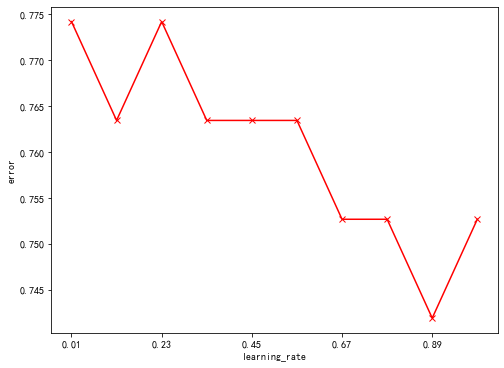

In [68]:
## 误差可视化
plt.figure(figsize=(8, 6))
plt.plot(error, 'r-x')
plt.xticks([0, 2, 4, 6, 8], [0.01, 0.23, 0.45, 0.67, 0.89])
plt.xlabel('learning_rate')
plt.ylabel('error')

分析：随着学习率的增大，步长越来越大，会使测试集误差下降，但过大的学习率会导致误差上升。

### AdaBoost(base_estimator=LogisticRegression)
> 基学习器为逻辑回归的AdaBoost()集成模型分析

#### 模型构建与评价

In [69]:
## 基分类器为逻辑回归
from  sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(random_state=10,class_weight="balanced")

## 构建AdaBoost()
model_adaLR = AdaBoostClassifier(base_estimator=model_LR,random_state=10)

## 集成训练
model_adaLR.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=10,
                                                     solver='warn', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0

In [70]:
## 模型预测及结果评价
## 预测概率值
y_prob_adaLR = model_adaLR.predict_proba(X_test)[:,1]
## 预测标签值
y_pred_daaLR = model_adaLR.predict(X_test)


In [71]:
##  计算AUC
fpr, tpr, threshold = roc_curve(y_true=y_test,y_score=y_prob_adaLR)
print('AUC值：', auc(fpr, tpr))

AUC值： 0.7252155172413793


Text(0.5, 1.0, 'ROC Curve')

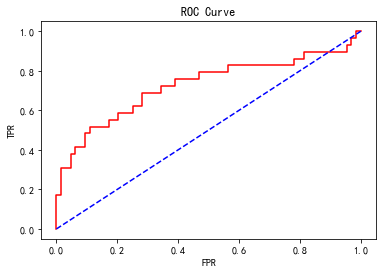

In [72]:
## 绘制ROC
plt.plot(fpr, tpr, 'r-')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### GridSearchCV优化
> 针对模型`AdaBoost(base_estimator=LogisticRegression)`进行网格寻优    <br>
> 可调参数：
>> (1) `'n_estimators'`:grid_n, [20, 50, 100, 150, 200, 500]  <br>
(2) `'learning_rate'`:grid_lr, linsapce(0.01, 1, 10)  <br>

>> 提示：运行需要一定时间

In [73]:
## 构造网格参数KV
grid_n = [20, 50, 100, 150, 200, 500]
grid_lr = np.linspace(0.01,1,10)
param_grid = {"n_estimators":grid_n,"learning_rate":grid_lr}

## 实例化GridSearchCV()
grid_search = GridSearchCV(estimator=model_adaLR,
                           param_grid=param_grid,
                           cv=5,
                           scoring="roc_auc"
                          )
## searching...
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=LogisticRegression(C=1.0,
                                                                            class_weight='balanced',
                                                                            dual=False,
                                                                            fit_intercept=True,
                                                                            intercept_scaling=1,
                                                                            l1_ratio=None,
                                                                            max_iter=100,
                                                                            multi_class='warn',
                                                                            n_jobs=None,
                                                      

In [74]:
## 返回最优参数
grid_search.best_params_

{'learning_rate': 0.56, 'n_estimators': 20}

In [75]:
## 考查最优模型性能

##  采用grid_search的最优模型进行预测
### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_adaLR_best = grid_search.predict_proba(X_test)[:,1]

### predict2：测试集的预测标签(y_pred)
y_pred_adaLR_best = grid_search.predict(X_test)

In [76]:
##  输出分类报告
print(classification_report(y_true=y_test,y_pred=y_pred_adaLR_best))


              precision    recall  f1-score   support

           0       0.78      0.91      0.84        64
           1       0.68      0.45      0.54        29

    accuracy                           0.76        93
   macro avg       0.73      0.68      0.69        93
weighted avg       0.75      0.76      0.75        93



分析：对于0类的召回率较高

AUC值： 0.7182112068965517


Text(0.5, 1.0, 'ROC Curve')

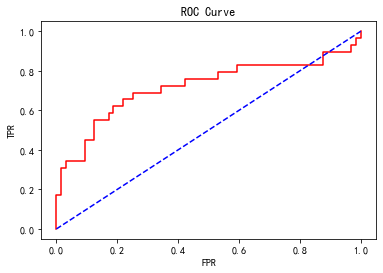

In [77]:
# 绘制ROC曲线并计算AUC
fpr, tpr, threshold = roc_curve(y_true=y_test,y_score=y_prob_adaLR_best )
print('AUC值：', auc(fpr, tpr))
plt.plot(fpr, tpr, 'r-')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

## GBDT
> **常用于回归任务**
>> ●梯度提升树，GBDT,Gradient Boosting Decision Tree  <br>
 ●以回归树为基学习器的boosting方法   <br>
 ●用损失函数的负梯度来拟合每轮损失的近似值   <br>


### GBDT回归
> ![](./imgs/chap07/fig07_04.png)

> `GradientBoostingRegressor`类
>> ![](./imgs/chap07/fig07_04_1.png)

>> 官方文档：https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

### GBDT分类(二分类）
>![](./imgs/chap07/fig07_05.png)

>`GradientBoostingClassifier`类
>> ![](./imgs/chap07/fig07_05_1.png)

>>官方文档：https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

#### GBDT(clf)分类模型构建

In [78]:
## 载入算法类
from sklearn.ensemble import GradientBoostingClassifier

## 建立并训练GBDT模型
model_gbdt = GradientBoostingClassifier(random_state=10,subsample=0.7)
model_gbdt.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### GBDT_clf模型预测

In [79]:
##  模型预测
### predcit1：测试集正类的预测概率（y_prob）(只看1标签的)
y_prob_gbdt = model_gbdt.predict_proba(X_test)[:,1]

### predict2：测试集的预测标签(y_pred)
y_pred_gbdt = model_gbdt.predict(X_test)

#### GBDT_clf模型评价

In [80]:
## 计算AUC
fpr,tpr,threshold = roc_curve(y_true=y_test,y_score=y_prob_gbdt)
print('AUC值：', auc(fpr, tpr))

AUC值： 0.7300646551724138


#### GBDT_clf模型参数
> 弱分类器袋外样本损失减小值和训练集损失
>> `oob_improvement_`:每增加一个基分类器，袋外样本的损失函数减少值<br>
`train_score_`:	每增加一个基分类器，训练集上损失函数的值


In [81]:
## 弱分类器袋外样本损失减小值和训练集损失
oob_improves = model_gbdt.oob_improvement_
train_scores = model_gbdt.train_score_

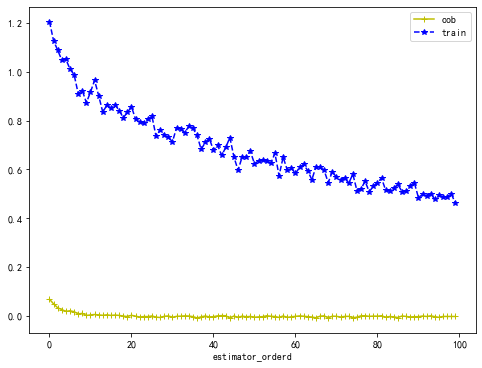

In [82]:
## 可视化
plt.figure(figsize=(8, 6))
plt.plot(model_gbdt.oob_improvement_, 'y-+', label='oob')
plt.plot(model_gbdt.train_score_, 'b--*', label='train')
plt.xlabel('estimator_orderd')
plt.legend()

分析：
> (1) 随着弱分类器的增加，训练集的损失在不断降低，袋外样本的损失减小值慢慢趋于平稳，<br>
(2)`GradientBoostingClassifier()`的弱分类器个数`n_estimator`默认100个，从图上看，用不着那么多，设置该参数为20就可以了

#### GBDT_clf的GridSearchCV()优化
> 可优化参数：
>> (1)'n_estimators':grid_n,    <br>
(2)'learning_rate':grid_rate,    <br>
(3)'subsample':grid_sub     <br>

In [83]:
import numpy as np
np.linspace(0.01,1,10)

array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])

In [84]:
## 构造网格参数KV
grid_n = [20, 50, 100, 150, 200, 500]
grid_lr = np.linspace(0.01,1,10)
grid_subsample = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
param_grid = {"n_estimators":grid_n,"learning_rate":grid_lr,"subsample":grid_subsample}

## 实例化GridSearchCV()
grid_search = GridSearchCV(estimator=model_gbdt,
                           param_grid=param_grid,
                           cv=5,
                           scoring="roc_auc"
                          )
## 网格搜索调参 searching
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  subsample=0.7, tol

In [85]:
## 获取最优参数
grid_search.best_params_

{'learning_rate': 0.12, 'n_estimators': 150, 'subsample': 0.3}

In [86]:
## 考查最优模型性能
## 采用grid_search的最优模型进行预测
### predcit1：测试集正类的预测概率（y_prob）
y_prob_gbdt_best = grid_search.predict_proba(X_test)[:,1]

### predict2：测试集的预测标签(y_pred)
y_pred_gbdt_best = grid_search.predict(X_test) 

In [87]:
## 输出分类报告
print(classification_report(y_true=y_test,y_pred=y_pred_gbdt_best))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86        64
           1       0.91      0.34      0.50        29

    accuracy                           0.78        93
   macro avg       0.84      0.66      0.68        93
weighted avg       0.81      0.78      0.75        93



AUC值： 0.7435344827586207


Text(0.5, 1.0, 'ROC Curve')

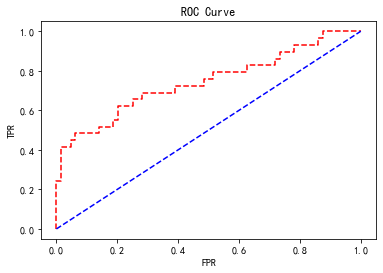

In [88]:
## 计算AUC
fpr,tpr,threshold = roc_curve(y_true=y_test,y_score=y_prob_gbdt_best)
print("AUC值：",auc(fpr,tpr))

## 绘制ROC曲线
plt.plot(fpr,tpr,'r--')
plt.plot([0,1],[0,1],'b--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")

#### 特征重要性考察
> + (1) 根据`grid_search`得到`best_gbdt`模型  <br>
> + (2) 使用`best_gbdt`进行模型训练`fit() ` <br>
> + (3) 获取`.feature_importances_` <br>
> + (4) 可视化

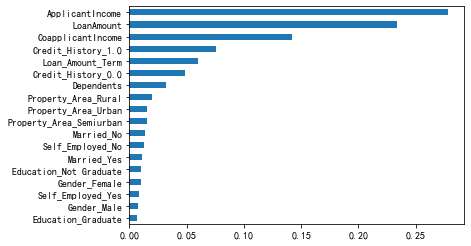

In [89]:
## (1)根据`grid_search`得到best_gbdt模型  <br>
best_gbdt = grid_search.best_estimator_

## (2)fit() 
best_gbdt.fit(X_train,y_train)

## (3)获取`.feature_importances_`
fea_importances = best_gbdt.feature_importances_

## (4)可视化
pd.Series(fea_importances,index=X_train.columns).sort_values().plot(kind="barh")


分析：没有违约历史、有违约历史、申请人收入、贷款金额、共同申请人收入这五个特征的重要性排在前五位

# VotingClassifier
> **一般用在最后一步，提升模型性能** <br>
> ● 投票表决器,是一种模型堆叠法：即建立多个不同基模型，将每个模型的预测结果当做输入，建立一个高层的综合模型，可以有效改进预测

>● 原理：组合不同的基分类器，最终通过多数投票（硬投票）或概率平均（软投票）的方式来预测样本类别

>>(1)硬投票：
>>>对于一个样本，每个基分类器都预测一个类别，所有的基分类器预测类别中最多的类将被作为最终结果 <br>

>>(2)软投票：
>>>◆在每个基分类器输出测试样本属于各个类的概率，将所有基分类器对每个类的预测概率进行平均得到最终测试样本属于每个类的概率，从中选择拥有最大概率的类 <br>
>>>◆对每个基分类器设置权重，用于对预测概率进行加权平均，以控制每个基分类器的贡献

> `VotingClassifier`类：
>> |参数	|功能|
|---:|---:|
|estimators	|基分类器设置，需传入一个元组列表|
|voting	|投票方式，默认为“hard”，软投票为“soft”|
|weights	|基分类器的权重，需传入一个列表对象|

>> 官网：https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html


## 单一模型的硬投票和软投票
> 硬投票流程：
>> (1) 构建两个单独模型:model_DF和model_LR  <br>
(2) 将以上两个单独的模型集成到投票器里，投票方式设置为"硬投票"  <br>
(3) 训练投票器     <br>
(4) 使用投票器预测标签(pred)  <br>
(5) 计算AUC

> 软投票流程(与上不同处)：
>> (2) 投票方式设置为"软投票"  <br>
(4) 使用投票器预测概率(proba)  <br>


### SingleModelHardVoting

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## 构建决策树模型：model_DF
model_DF = DecisionTreeClassifier(random_state=10)

## 构建线性回归模型：model_LR
model_LR= LogisticRegression(random_state=10,class_weight="balanced")

In [91]:
## 载入`VotingClassifier`类
from sklearn.ensemble import VotingClassifier

## 将模型放入投票器中
model_vote_hard = VotingClassifier(estimators=[("DF",model_DF),("LR",model_LR)],voting = "hard")
## 投票训练     
model_vote_hard.fit(X_train,y_train)

VotingClassifier(estimators=[('DF',
                              DecisionTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=10,
                                                     splitter='best')),
        

In [92]:
## 得到预测标签
y_pred_vote_hard = model_vote_hard.predict(X_test)

In [93]:
## 计算AUC
fpr,tpr,threshold = roc_curve(y_true=y_test,y_score=y_pred_vote_hard)
print('SingleModel硬投票AUC值：', auc(fpr, tpr))

SingleModel硬投票AUC值： 0.6740301724137931


### SingleModelSoftVoting

In [94]:
# 单一模型的软投票
model_vote_soft = VotingClassifier(estimators=[('DF',model_DF), ('LR',model_LR)], voting='soft')
model_vote_soft.fit(X_train, y_train)

# 得到预测概率,(只看1标签的)
y_prob_vote_soft = model_vote_soft.predict_proba(X_test)[:, 1]
# 计算AUC
fpr, tpr, threshold = roc_curve(y_score=y_prob_vote_soft, y_true=y_test)

print('SingleModel软投票AUC值：', auc(fpr, tpr))

SingleModel软投票AUC值： 0.8033405172413793


结论：通过硬投票、软投票的AUC值，可知软投票效果明显比硬投票好

## 集成模型的硬投票和软投票
> 采用两个集成模型进行实验：
>> (1) `RandomForest`：典型的Bagging,集成了多棵决策树  <br>
(2) `GradientBoostingRegressor`:典型的Boosting   <br>

>流程与SingleModel相同

### EnsembleModelHardVoting

In [95]:
## 创建两个集成模型
best_RF = RandomForestClassifier(max_features=6, n_estimators=500, random_state=10)
best_gbdt = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, subsample=0.3, random_state=10)

## 将模型放入投票器中
model_vote_hard = VotingClassifier(estimators=[('RF',best_RF), ('GBDT',best_gbdt)],voting = "hard")

## 投票训练  
model_vote_hard.fit(X_train, y_train)

# 得到预测标签
y_pred_vote_hard = model_vote_hard.predict(X_test)

# 计算AUC
fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_pred_vote_hard)
print('EnsembleModel硬投票AUC值：', auc(fpr, tpr))

EnsembleModel硬投票AUC值： 0.6646012931034483


### EnsembleModelSofVoting

In [96]:
## 集成模型软投票
model_vote_soft = VotingClassifier(estimators=[('RF',best_RF), ('GBDT',best_gbdt)],voting="soft")
model_vote_soft.fit(X_train,y_train)

# 得到预测概率
y_prob_vote_soft = model_vote_soft.predict_proba(X_test)[:,1]

# 计算AUC
fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_prob_vote_soft)
print('EnsembleModel软投票AUC值：', auc(fpr, tpr))

EnsembleModel软投票AUC值： 0.790948275862069


结论： EnsembleModel软投票AUC值 > EnsembleModel硬投票AUC值

## AUC值加权软投票
> 根据各基分类模型的AUC进行加权软投票，哪个模型的AUC值高，就说明该模型重要性高,在投票时的话语权就重。
>> 流程：
>>> (1) 获得单一模型的AUC值：AUC1,AUC2,...  <br>
(2) 构建weights=[AUC1,AUC2,...]   <br>
(3) 创建加权的投票器    <br>
(4) 训练投票器    <br>
(5) 预测&评价    <br>

In [97]:
## 获得单一模型的AUC值
model_DF.fit(X_train, y_train)
y_prob_DF = model_DF.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_score=y_prob_DF, y_true=y_test)
print('(1)决策树AUC值：', auc(fpr, tpr))

model_LR.fit(X_train, y_train)
y_prob_LR = model_LR.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_score=y_prob_LR, y_true=y_test)
print('(2)逻辑回归AUC值：', auc(fpr, tpr))

(1)决策树AUC值： 0.7634698275862069
(2)逻辑回归AUC值： 0.7268318965517242


In [98]:
## 构建weights
weights = [0.76, 0.73]

## 构建加权的软投票器
model_vote_soft = VotingClassifier(estimators=[('DF',model_DF), ('LR',model_LR)], voting='soft', weights=weights)

## 训练投票器
model_vote_soft.fit(X_train, y_train)

# 得到预测概率
y_prob_vote_soft = model_vote_soft.predict_proba(X_test)[:, 1]

# 计算AUC
fpr, tpr, threshold = roc_curve(y_score=y_prob_vote_soft, y_true=y_test)
print('软投票AUC值：', auc(fpr, tpr))

软投票AUC值： 0.8033405172413793


结论:与4.1结果持平，原因是weights = [0.76, 0.73]，差距较小。

# 小结
> 集成模型的应用场合：竞赛，工业应用场景 <br>
> 集成模型大致可分为：
>> bagging(并行思想): 各个基模型相互独立；从方差-偏差的角度看，可以有效减小方差,用于抑制模型过拟合，提升模型稳定性。
>>> 典型1：随机森林RF

>> boosting(串行思想): 各个基模型从前往后高度相关；从方差-偏差的角度看，可以有效减小偏差，提升模型精度。
>>> 典型1：AdaBoost，常用于分类任务   <br>
>>> 典型2：GDBT，常用于回归任务    <br>

>> voting(堆叠思想):即可用于SingleModel亦可用于EnsembleModel
>>> 硬投票   <br>
>>> 软投票    <br>
>>> 加权投票    <br>